# Exploratory Data Analysis (EDA) for Credit Risk Engine

## Initial steps

Load libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Reproducibility and display

In [2]:
np.random.seed(42)
pd.options.display.max_columns = 200
sns.set_palette('Set2')

We load the dataset we cleaned in the `data_ingestion.ipynb` notebook and define the color palette to use for visualizations.

In [3]:
df = pd.read_csv('../data/credit_risk_cleaned.csv')
print('Loaded dataset shape:', df.shape)
df.head()


Loaded dataset shape: (31679, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,N,2,1


## Correlations

We start looking for relevant features by checking their correlation with the target variable

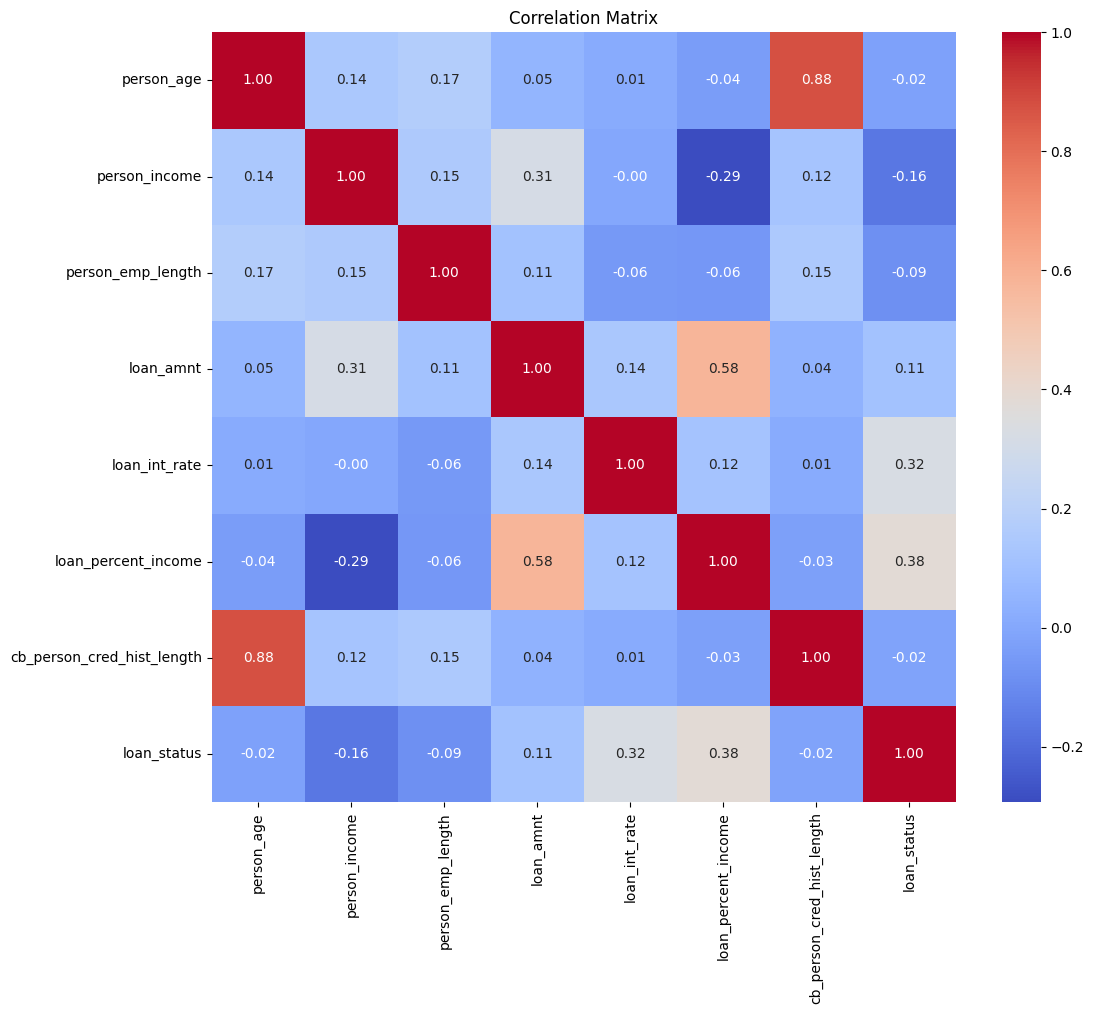

In [4]:
# We get the numeric columns for the correlation matrix
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_df = df[numeric_cols]

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

As we can see there are not many strong correlations between the dataset features but we can highlight:

- **Strong positive correlation between person_age and cb_person_cred_hist_length (0.88)**: This makes sense since the older the person is, the longer their credit history is likely to be.

- **Moderate positive correlation between loan_percent_income and loan_amnt (0.58)**: This also makes sense since the higher the loan amount, the higher the percentage of income that is likely to be allocated to paying that loan.

- **Relatively low positive correlation of loan_status (target) with loan_int_rate (0.32) and loan_percent_income (0.38)**: It makes sense since the higher the interest rate and the higher the percentage of income allocated to the loan, the more likely it is to default.

To see the correlation between the target variable and its most correlated features we can use boxplots.

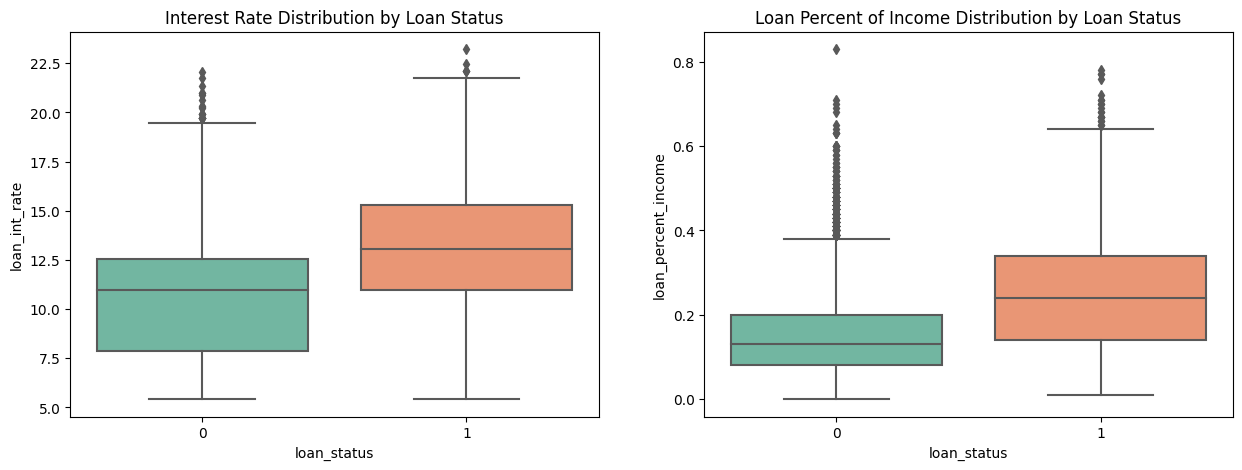

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Interest rate distribution by loan status
sns.boxplot(x='loan_status', y='loan_int_rate', data=df, ax=axes[0])
axes[0].set_title('Interest Rate Distribution by Loan Status')

# Loan percentage of income distribution by loan status
sns.boxplot(x='loan_status', y='loan_percent_income', data=df, ax=axes[1])
axes[1].set_title('Loan Percent of Income Distribution by Loan Status')

plt.show()


We can see a clear correlation between these two features and the target variable, which is consistent with our expectations. Higher interest rates and higher loan percentages of income are associated with a higher likelihood of default.

## Outlier handling

We move on to outlier handling, we can extract the outlier count, percentage and skewness of all numeric cols (excluiding target variable)

In [6]:
# Outlier detection (IQR rule) and distribution plots for numeric features
iqr_outliers = []
for col in numeric_cols[:-1]:  # Skip target variable
    series = df[col].dropna()
    if series.empty:
        continue
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_count = int(((series < lower) | (series > upper)).sum())
    outlier_pct = 100.0 * outlier_count / len(df)
    iqr_outliers.append((col, outlier_count, outlier_pct, series.skew()))

outlier_df = pd.DataFrame(iqr_outliers, columns=['feature','outlier_count','outlier_pct','skew']).set_index('feature').sort_values('outlier_pct', ascending=False)
outlier_df.head(20)

,outlier_count,outlier_pct,skew
feature,,,
loan_amnt,1635,5.161148,1.181859
person_income,1460,4.608731,9.815297
person_age,1455,4.592948,1.948644
cb_person_cred_hist_length,1115,3.519682,1.666861
person_emp_length,851,2.686322,1.247889
loan_percent_income,614,1.938192,1.068953
loan_int_rate,58,0.183087,0.219361


As we can see on the outlier summary we have features with up to a 5% of outliers, which is significant. Let's plot the distribution of the numeric features to get a better understanding of the reesults.

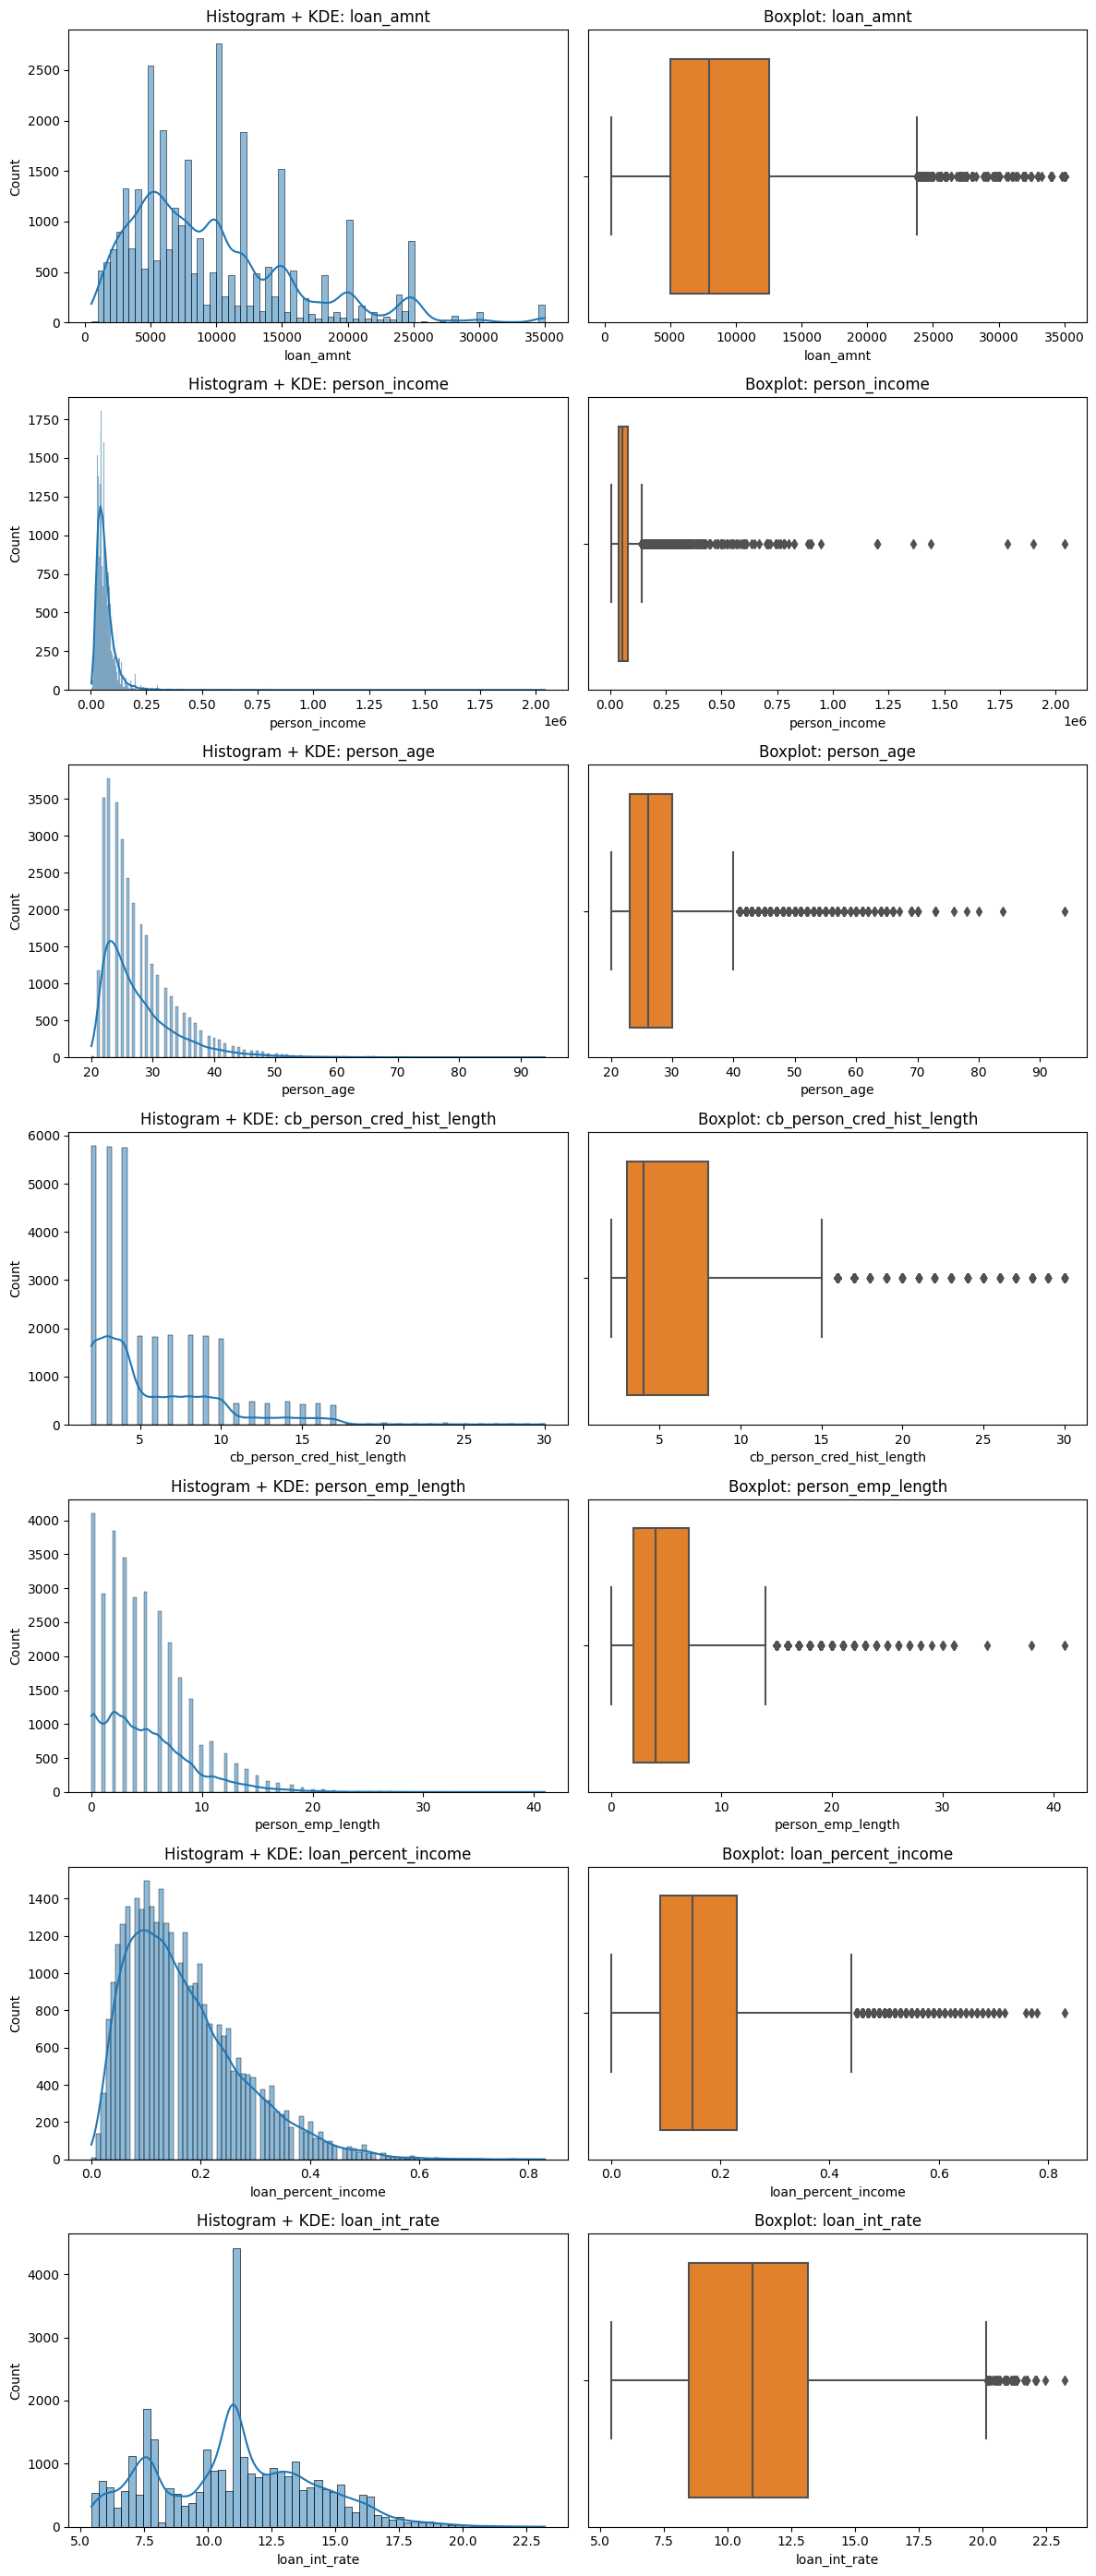

In [7]:
top_plot_cols = list(outlier_df.sort_values(['outlier_pct','skew'], ascending=[False, False]).index)
if top_plot_cols:
    n = len(top_plot_cols)
    fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))
    for i, col in enumerate(top_plot_cols):
        ax_hist = axes[i,0] if n>1 else axes[0]
        ax_box = axes[i,1] if n>1 else axes[1]
        sns.histplot(df[col].dropna(), kde=True, ax=ax_hist, color='tab:blue')
        ax_hist.set_title(f'Histogram + KDE: {col}')
        sns.boxplot(x=df[col], ax=ax_box, color='tab:orange')
        ax_box.set_title(f'Boxplot: {col}')
    plt.tight_layout()
    plt.show()
else:
    print('No numeric features available for distribution plotting')

In [8]:
#fix the skewed features by log transformation (add 1 to avoid log(0))
skewed_cols = outlier_df[outlier_df['skew'] > 1].index
for col in skewed_cols: 
    df[col] = np.log1p(df[col])

                            outlier_count  outlier_pct      skew
feature                                                         
person_age                            745     2.351716  1.180026
person_income                         537     1.695129  0.178262
loan_amnt                             446     1.407873 -0.448557
loan_percent_income                   412     1.300546  0.821027
loan_int_rate                          58     0.183087  0.219361
cb_person_cred_hist_length             22     0.069447  0.487523
person_emp_length                       3     0.009470 -0.458508


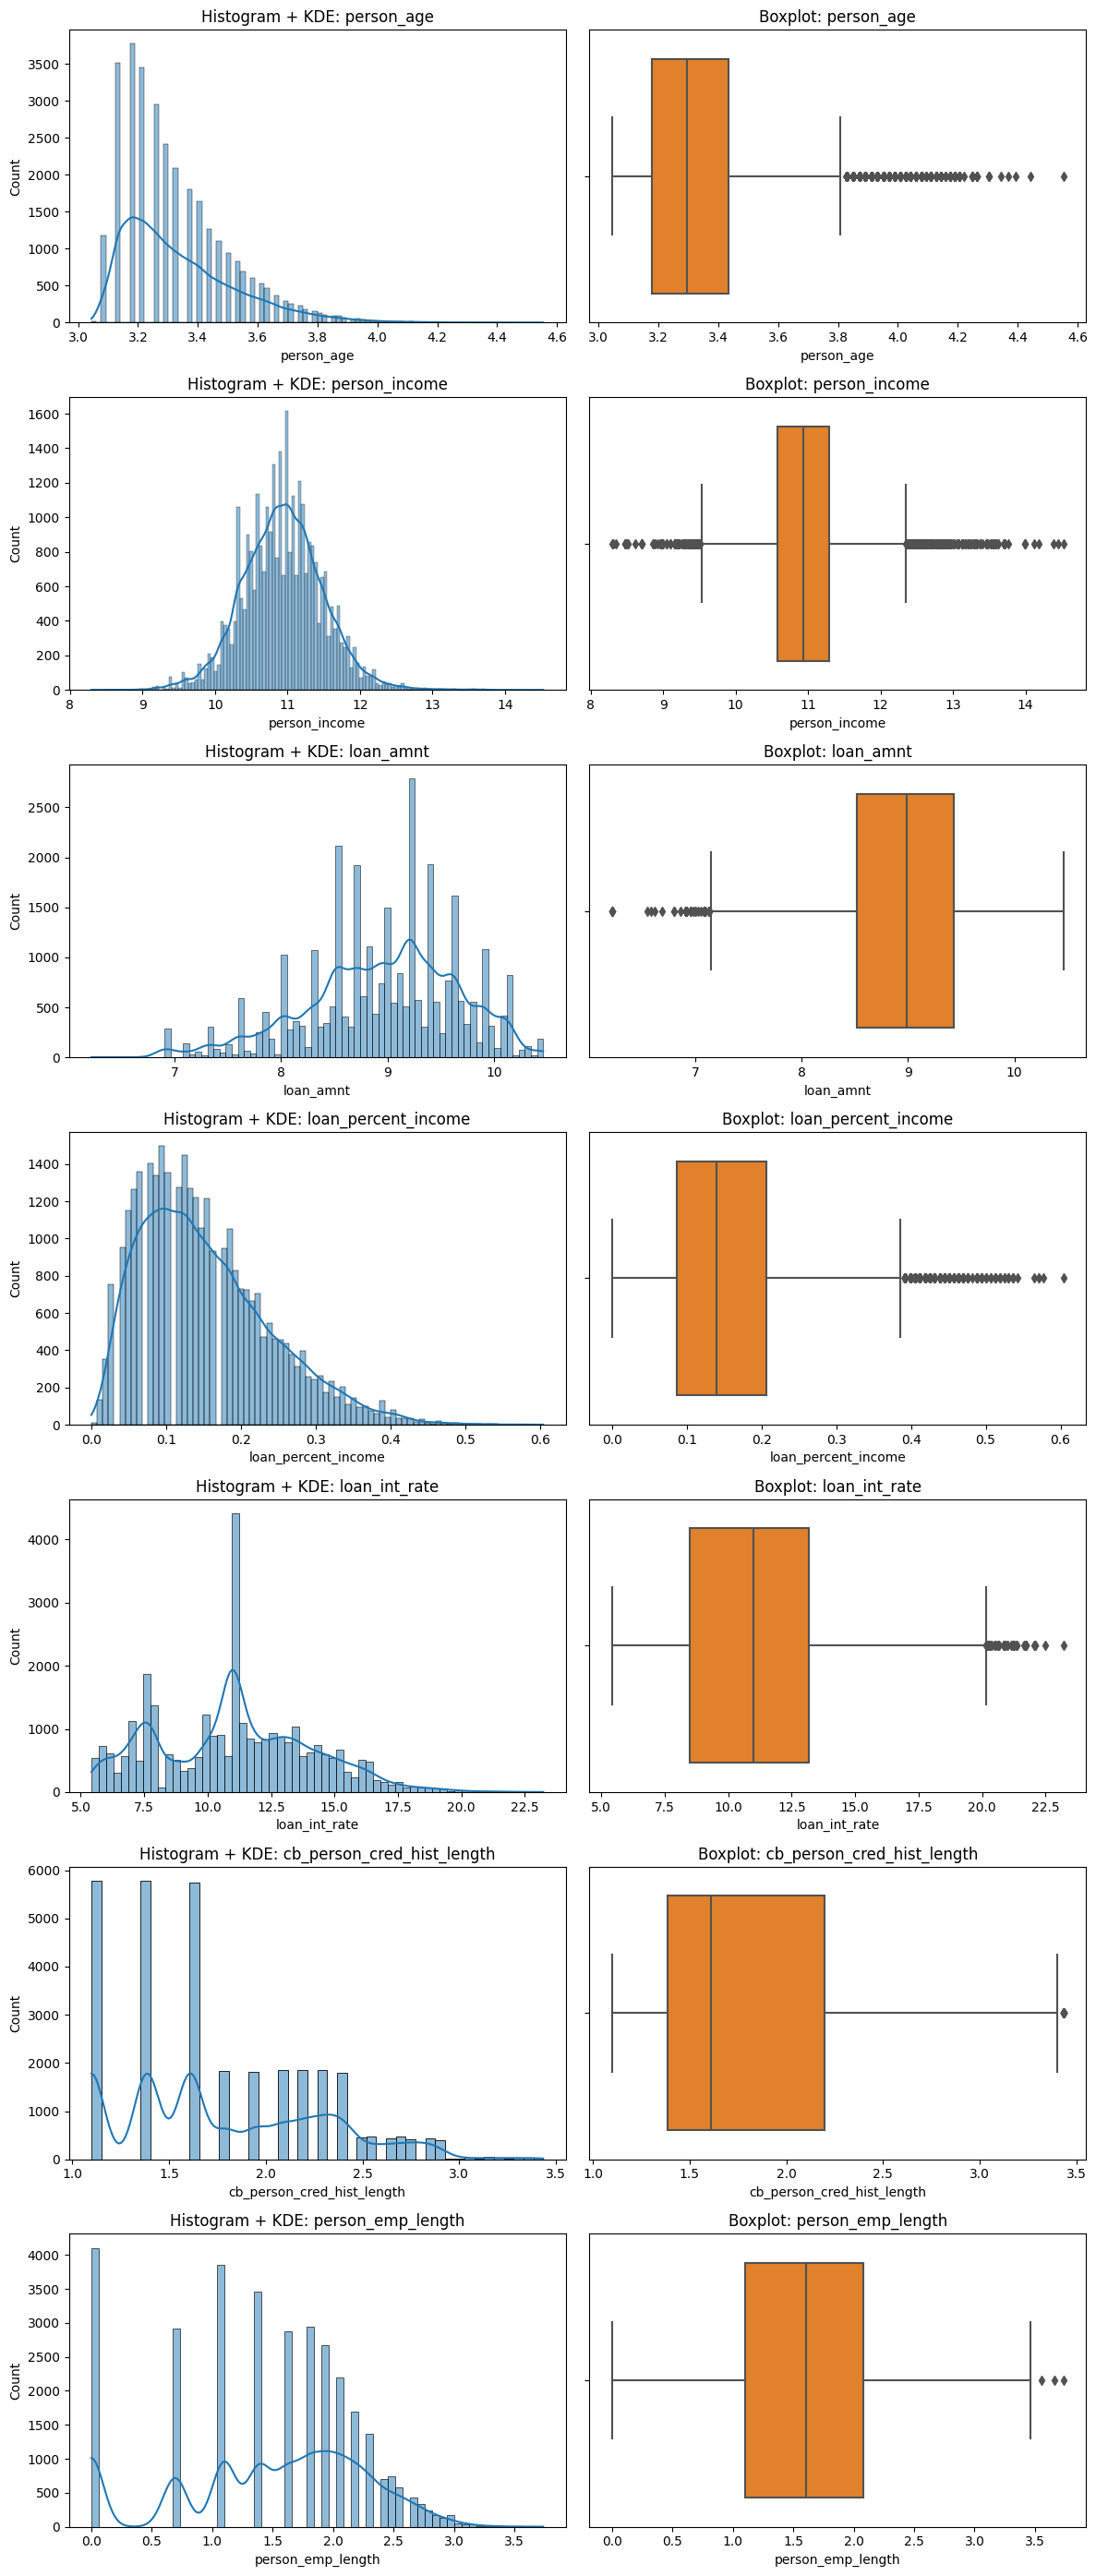

In [9]:
# Outlier detection (IQR rule) and distribution plots for numeric features
iqr_outliers = []
for col in numeric_cols[:-1]:  # Skip target variable
    series = df[col].dropna()
    if series.empty:
        continue
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_count = int(((series < lower) | (series > upper)).sum())
    outlier_pct = 100.0 * outlier_count / len(df)
    iqr_outliers.append((col, outlier_count, outlier_pct, series.skew()))

outlier_df = pd.DataFrame(iqr_outliers, columns=['feature','outlier_count','outlier_pct','skew']).set_index('feature').sort_values('outlier_pct', ascending=False)
print(outlier_df.head(20))

top_plot_cols = list(outlier_df.sort_values(['outlier_pct','skew'], ascending=[False, False]).index)
if top_plot_cols:
    n = len(top_plot_cols)
    fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))
    for i, col in enumerate(top_plot_cols):
        ax_hist = axes[i,0] if n>1 else axes[0]
        ax_box = axes[i,1] if n>1 else axes[1]
        sns.histplot(df[col].dropna(), kde=True, ax=ax_hist, color='tab:blue')
        ax_hist.set_title(f'Histogram + KDE: {col}')
        sns.boxplot(x=df[col], ax=ax_box, color='tab:orange')
        ax_box.set_title(f'Boxplot: {col}')
    plt.tight_layout()
    plt.show()
else:
    print('No numeric features available for distribution plotting')

As we can see, the log transformation has reduced skewness and outliers for the most problematic features, making them more suitable for modeling. But there are still some features that are not fully normalized, and further transformations or feature engineering may be needed to improve performance

## Categorical variables

Now we can move on with the categorical variables. We define a function to add percentages to each category of the categorical features.

In [10]:
def plot_categorical_distribution(df, x_col, hue_col):
    """
    Plots a countplot with percentages normalized within each x-axis category.
    """
    # 1. Calculate group totals for normalization
    group_counts = df.groupby(x_col).size()

    plt.figure(figsize=(10, 5))
    
    # 2. Create the plot
    ax = sns.countplot(x=x_col, hue=hue_col, data=df)
    
    # 3. Handle x-axis labels
    plt.xticks(rotation=45, ha='right')
    all_categories = [t.get_text() for t in ax.get_xticklabels()]

    # 4. Add annotations
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only annotate bars that have data
            # Calculate category index based on bar center
            category_idx = int(round(p.get_x() + p.get_width() / 2))
            
            if category_idx < len(all_categories):
                x_category = all_categories[category_idx]
                group_total = group_counts[x_category]
                
                percentage = f'{(100 * height / group_total):.1f}%'
                
                ax.annotate(percentage, 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='bottom', 
                            xytext=(0, 5), 
                            textcoords='offset points',
                            fontsize=11,
                            fontweight='bold')

    # 5. Final styling
    plt.title(f'{hue_col} Distribution within {x_col}')
    
    # Dynamic ylim to avoid cutting off labels
    max_bar = max([p.get_height() for p in ax.patches if not np.isnan(p.get_height())], default=10)
    plt.ylim(0, max_bar * 1.1)
    
    plt.tight_layout()
    plt.show()

And use it on each categorical variable

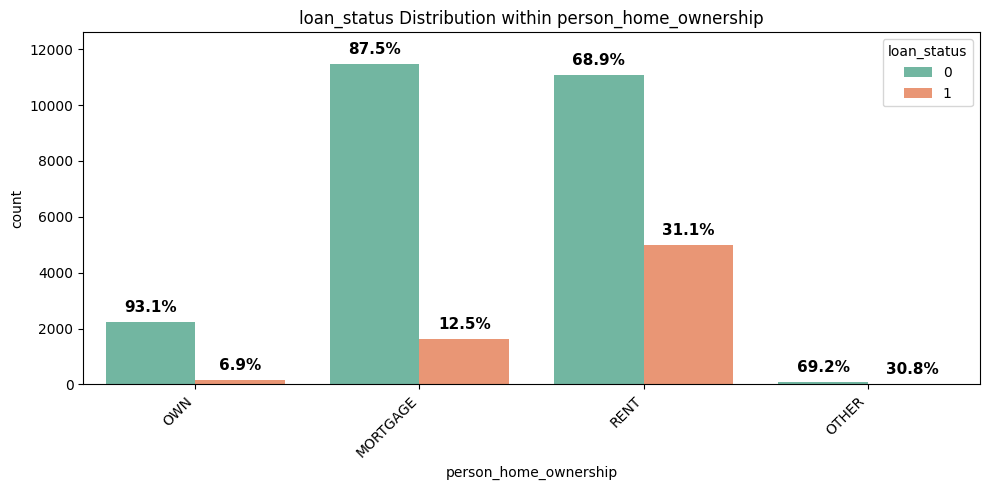

In [11]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

plot_categorical_distribution(df, categorical_cols[0], 'loan_status')

There is a clear relationship between the loan status and the home ownership status, having really low default rates on people that own their home (less than 7%), a higher default rate on people that have a mortgage (12.5%) and the highest default rate on people that rent their home (31.1%) and other situations.

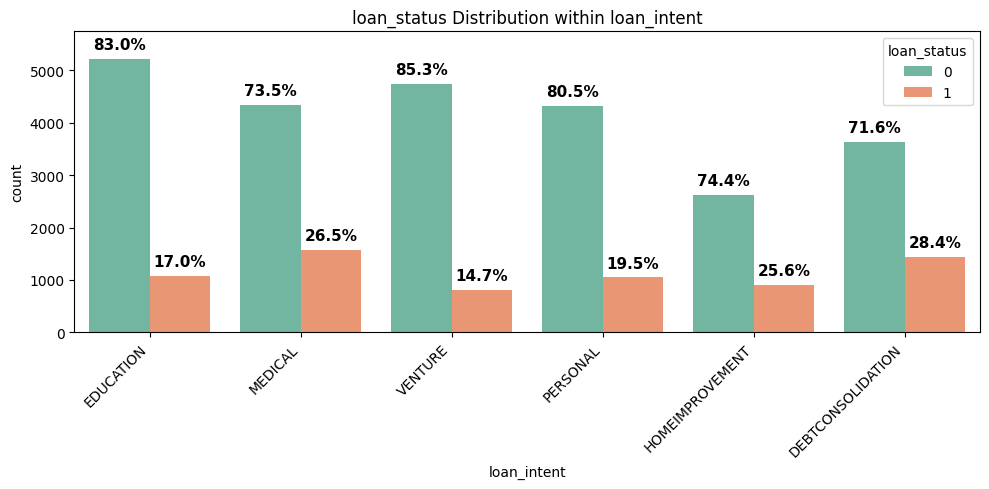

In [12]:
plot_categorical_distribution(df, categorical_cols[1], 'loan_status')

As we can see all categories on loan_intent distributions range from ~70% (debt consolidation) to ~85% (ventures) of non-defaults

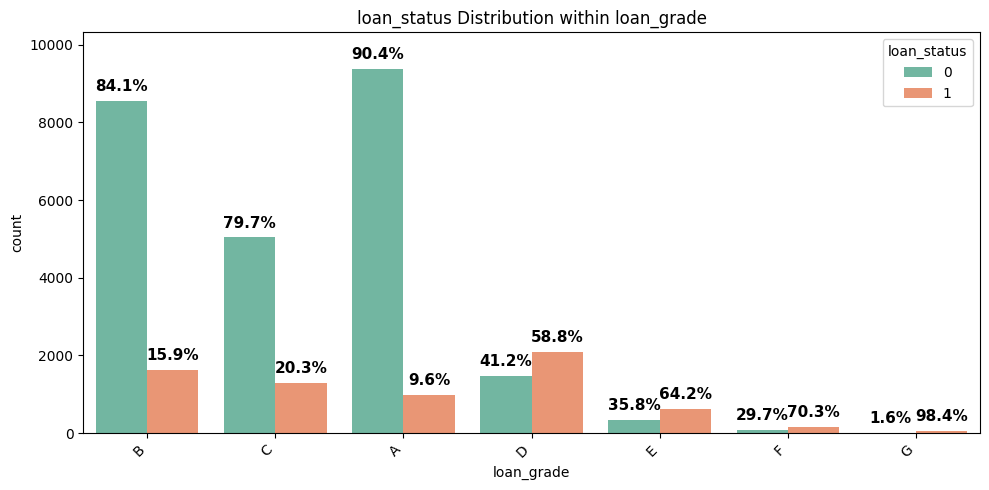

In [13]:
plot_categorical_distribution(df, categorical_cols[2], 'loan_status')

Loan grades can be divided in two groups: A-C and D-G. The first group has a higher percentage of fully paid loans, while the second group has a higher percentage of charged off loans. The default rate is higher as the loan grade gets worse.

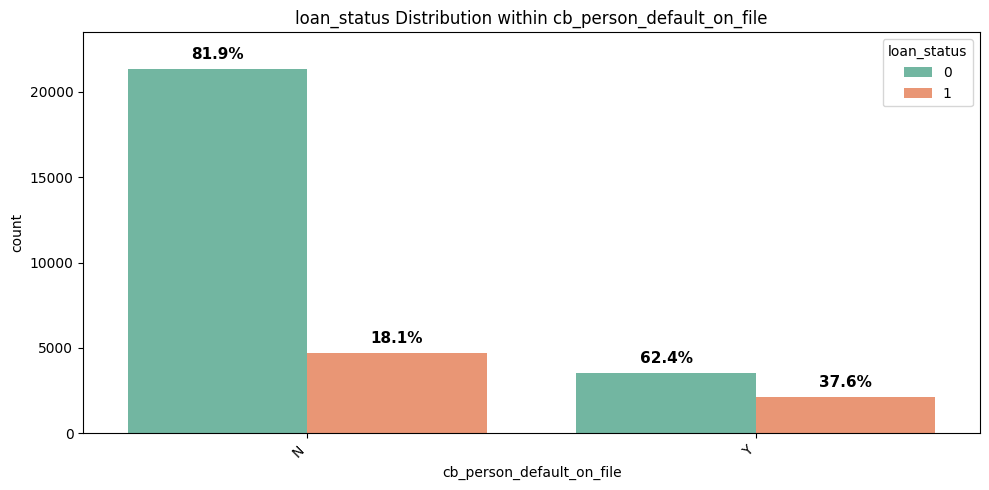

In [14]:
plot_categorical_distribution(df, categorical_cols[3], 'loan_status')

People that don't have a default on file have a much higher percentage of paid loans (81.9%) than those that have it (62.4%).

## Save data for next steps

In [15]:
os.makedirs('../data', exist_ok=True)
outlier_df.to_csv('../data/credit_risk_unskewed.csv')

## Summary

To summarize what we found in this data exploration:

- We observed that some features are highly correlated, for example person_age and cb_person_cred_hist_length.
- We found that some features have a high percentage of outliers which we reducedd applying a log transformation.
- We also observed that some categorical features options are related to the target variable, for example loan grades from A to C have a much higher percentage of fully paid loans than grades D to G.